In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F
import seaborn as sns

from pyspark.sql.functions import col, round, expr, count, mean, min, max, stddev, skewness, kurtosis, percentile_approx, lit, split, explode, trim, regexp_replace, transform, array_contains, when, regexp_extract, coalesce
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

from pyspark.sql.functions import col, regexp_replace

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table
import utils.generator_fn as dg


## set up pyspark session

In [5]:
# Initialize SparkSession, sets up pyspark cluster on computer.
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## set up config

In [17]:
lms_df = pd.read_csv('data/lms_loan_daily.csv')
# lms_df = pd.read_csv('data/feature_clickstream.csv')
lms_df.sort_values("snapshot_date")

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
83523,CUS_0x81e6_2023_01_01,CUS_0x81e6,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
136686,CUS_0xed3_2023_01_01,CUS_0xed3,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
107063,CUS_0xa182_2023_01_01,CUS_0xa182,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
35057,CUS_0x41c_2023_01_01,CUS_0x41c,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
6611,CUS_0x19ad_2023_01_01,CUS_0x19ad,2023-01-01,10,0,10000,0.0,0.0,0.0,10000.0,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...
45638,CUS_0x4f04_2025_01_01,CUS_0x4f04,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
137059,CUS_0xf60_2025_01_01,CUS_0xf60,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
135365,CUS_0xcfd_2025_01_01,CUS_0xcfd,2025-01-01,10,10,10000,1000.0,0.0,7000.0,7000.0,2025-11-01
132549,CUS_0xc3b8_2025_01_01,CUS_0xc3b8,2025-01-01,10,10,10000,1000.0,0.0,7000.0,7000.0,2025-11-01


In [9]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2025-11-01"

In [10]:
dates_str_lst = dg.generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01',
 '2025-01-01',
 '2025-02-01',
 '2025-03-01',
 '2025-04-01',
 '2025-05-01',
 '2025-06-01',
 '2025-07-01',
 '2025-08-01',
 '2025-09-01',
 '2025-10-01',
 '2025-11-01']

## Build Bronze Table

In [10]:
# create bronze datalake
bronze_lms_directory = "datamart/bronze/lms/"

if not os.path.exists(bronze_lms_directory):
    os.makedirs(bronze_lms_directory)

In [18]:
# run bronze backfill, takes in date, directory and spark obj so that it can process the data and will run across the dates
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_lms_directory, spark)


2023-01-01row count: 530
saved to: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv
2023-02-01row count: 1031
saved to: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv
2023-03-01row count: 1537
saved to: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv
2023-04-01row count: 2047
saved to: datamart/bronze/lms/bronze_loan_daily_2023_04_01.csv
2023-05-01row count: 2568
saved to: datamart/bronze/lms/bronze_loan_daily_2023_05_01.csv
2023-06-01row count: 3085
saved to: datamart/bronze/lms/bronze_loan_daily_2023_06_01.csv
2023-07-01row count: 3556
saved to: datamart/bronze/lms/bronze_loan_daily_2023_07_01.csv
2023-08-01row count: 4037
saved to: datamart/bronze/lms/bronze_loan_daily_2023_08_01.csv
2023-09-01row count: 4491
saved to: datamart/bronze/lms/bronze_loan_daily_2023_09_01.csv
2023-10-01row count: 4978
saved to: datamart/bronze/lms/bronze_loan_daily_2023_10_01.csv
2023-11-01row count: 5469
saved to: datamart/bronze/lms/bronze_loan_daily_2023_11_01.csv
2023-12-01row count: 5

In [19]:
# inspect output
utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_lms_directory, spark).toPandas()

2025-11-01row count: 526
saved to: datamart/bronze/lms/bronze_loan_daily_2025_11_01.csv


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x1009_2025_01_01,CUS_0x1009,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
1,CUS_0x1098_2025_01_01,CUS_0x1098,2025-01-01,10,10,10000,1000.0,0.0,8000.0,8000.0,2025-11-01
2,CUS_0x109f_2025_01_01,CUS_0x109f,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
3,CUS_0x10b6_2025_01_01,CUS_0x10b6,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
4,CUS_0x10e2_2025_01_01,CUS_0x10e2,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
...,...,...,...,...,...,...,...,...,...,...,...
521,CUS_0xf15_2025_01_01,CUS_0xf15,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
522,CUS_0xf60_2025_01_01,CUS_0xf60,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
523,CUS_0xf74_2025_01_01,CUS_0xf74,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
524,CUS_0xf95_2025_01_01,CUS_0xf95,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01


## Build Silver Table

In [12]:
# create bronze datalake
silver_loan_daily_directory = "datamart/silver/loan_daily/"

if not os.path.exists(silver_loan_daily_directory):
    os.makedirs(silver_loan_daily_directory)

In [11]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_table(date_str, bronze_lms_directory, silver_loan_daily_directory, spark)


loaded from: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv row count: 530
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv row count: 1031
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv row count: 1537
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_04_01.csv row count: 2047
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_04_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_05_01.csv row count: 2568
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_05_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_06_01.csv row count: 3085
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_06_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_07_01.csv

In [12]:
utils.data_processing_silver_table.process_silver_table(date_str, bronze_lms_directory, silver_loan_daily_directory, spark).toPandas()

loaded from: datamart/bronze/lms/bronze_loan_daily_2025_11_01.csv row count: 526
saved to: datamart/silver/loan_daily/silver_loan_daily_2025_11_01.parquet


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date,mob,installments_missed,first_missed_date,dpd
0,CUS_0x1009_2025_01_01,CUS_0x1009,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
1,CUS_0x1098_2025_01_01,CUS_0x1098,2025-01-01,10,10,10000.0,1000.0,0.0,8000.0,8000.0,2025-11-01,10,8,2025-03-01,245
2,CUS_0x109f_2025_01_01,CUS_0x109f,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
3,CUS_0x10b6_2025_01_01,CUS_0x10b6,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
4,CUS_0x10e2_2025_01_01,CUS_0x10e2,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,CUS_0xf15_2025_01_01,CUS_0xf15,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
522,CUS_0xf60_2025_01_01,CUS_0xf60,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
523,CUS_0xf74_2025_01_01,CUS_0xf74,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
524,CUS_0xf95_2025_01_01,CUS_0xf95,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0


## EDA on credit labels

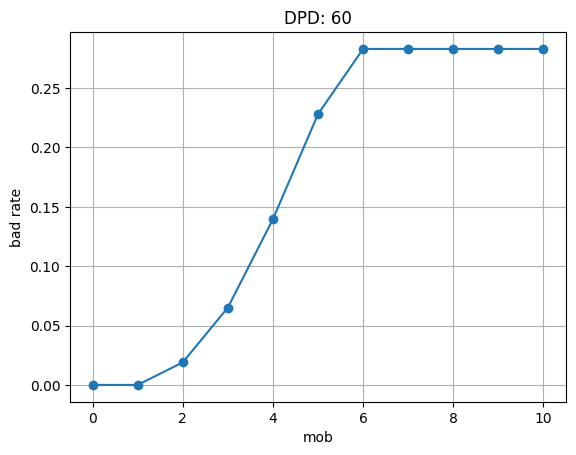

In [13]:
# set dpd label definition. dpd = date past due
dpd = 60

# Path to the folder containing CSV files
folder_path = silver_loan_daily_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [16]:
df.show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|             loan_id|Customer_ID|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|dpd_flag|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|CUS_0x1011_2023_1...| CUS_0x1011|     2023-11-01|    10|             10| 10000.0| 1000.0|  1000.0|        0.0|    0.0|   2024-09-01| 10|                  0|             NULL|  0|       0|
|CUS_0x1013_2023_1...| CUS_0x1013|     2023-12-01|    10|              9| 10000.0| 1000.0|  1000.0|        0.0| 1000.0|   2024-09-01|  9|                  0|             NULL|  0|       0|
|CUS_0x1018_2023_1...| CUS_0x1018|     2023-11-01|    1

## Build gold table for labels

In [ ]:
# create bronze datalake
gold_label_store_directory = "datamart/gold/label_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

In [ ]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)


loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet row count: 530
saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet row count: 1031


saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet row count: 1537
saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_04_01.parquet row count: 2047


saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_05_01.parquet row count: 2568
saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_06_01.parquet row count: 3085
saved to: datamart/gold/label_store/gold_label_store_2023_06_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_07_01.parquet row count: 3556


saved to: datamart/gold/label_store/gold_label_store_2023_07_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_08_01.parquet row count: 4037
saved to: datamart/gold/label_store/gold_label_store_2023_08_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_09_01.parquet row count: 4491
saved to: datamart/gold/label_store/gold_label_store_2023_09_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_10_01.parquet row count: 4978


saved to: datamart/gold/label_store/gold_label_store_2023_10_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_11_01.parquet row count: 5469


saved to: datamart/gold/label_store/gold_label_store_2023_11_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_12_01.parquet row count: 5428
saved to: datamart/gold/label_store/gold_label_store_2023_12_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_01_01.parquet row count: 5412
saved to: datamart/gold/label_store/gold_label_store_2024_01_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_02_01.parquet row count: 5424
saved to: datamart/gold/label_store/gold_label_store_2024_02_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_03_01.parquet row count: 5425
saved to: datamart/gold/label_store/gold_label_store_2024_03_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_04_01.parquet row count: 5417


saved to: datamart/gold/label_store/gold_label_store_2024_04_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_05_01.parquet row count: 5391
saved to: datamart/gold/label_store/gold_label_store_2024_05_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_06_01.parquet row count: 5418
saved to: datamart/gold/label_store/gold_label_store_2024_06_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_07_01.parquet row count: 5442
saved to: datamart/gold/label_store/gold_label_store_2024_07_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_08_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_08_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_09_01.parquet row count: 5537
saved to: datamart/gold/label_store/gold_label_store_2024_09_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_10_01.parquet row count: 5502


saved to: datamart/gold/label_store/gold_label_store_2024_10_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_11_01.parquet row count: 5501


saved to: datamart/gold/label_store/gold_label_store_2024_11_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet


In [ ]:
utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6).dtypes

loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('label', 'int'),
 ('label_def', 'string'),
 ('snapshot_date', 'date')]

## inspect label store

In [ ]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())
# gold table because it is ready for ML model
df.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [ ]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)

